In [2]:
import os
import re
import sys
import glob
import random
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
from Bio import pairwise2, SeqRecord, Seq
from Bio.Data import CodonTable

import pymutspec
from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id, CodonAnnotation
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.io import GenesStates

## Zeros for cosine similarity

In [13]:
a = [5,1,40,2,10]
b = [0,2,34,4,18]

print("CosSim:", 1-spatial.distance.cosine(a,b))

CosSim: 0.9621948256285112


In [16]:
a = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,40,2,10]
b = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,34,4,18]

print("CosSim:", 1-spatial.distance.cosine(a,b))

CosSim: 0.9621948256285113


## Prepare Data

### Mammals outgrp mito

In [2]:
ref = next(SeqIO.parse("../data/mammals/raw/outgrp.gb", format="gb"))
ref.description

'Cociella crocodila voucher HABs-2016-007 mitochondrion, complete genome'

In [46]:
for f in ref.features:
    if f.type == "CDS":
        if f.qualifiers["gene"] == ['CYTB']:
            cytb = str(f.extract(ref.seq))
        if f.qualifiers["gene"] == ['ND1']:
            nd1 = str(f.extract(ref.seq))

In [47]:
print(cytb)
print(nd1)

ATGGCCAACTTACGAAAAACCCACCCCTTACTCAAAATTGCTAACAATGCTTTAGTAGACCTCCCCGCCCCCTCCAACATCTCCGCATGATGAAACTTTGGGTCCCTTTTAGGACTATGCTTAATTATCCAAATCCTCTCAGGCTTATTTCTAGCTATACATTACACATCAGATGTCGCTACAGCCTTCTCCTCCGTTGCCCACATCTGCCGAGACGTAAATTACGGCTGGCTAATTCGCAATCTCCACGCAAACGGAGCATCATTCTTTTTTATCTGCATTTATATACACATCGGACGCGGCCTCTACTACGGATCATACCTTTTTAAAGAGACATGAAACATTGGCGTCGTGCTCTTGCTCCTCGTAATAGTCACCGCTTTCGTGGGCTACGTCCTCCCCTGAGGACAAATATCATTCTGAGGCGCCACGGTTATTACCAACCTTCTGTCCGCCGTCCCTTATATTGGTAACACCCTCGTTCAATGAATCTGAGGAGGCTTCTCAGTAGATAATGCTACATTAAACCGTTTCTTCGCGTTCCATTTCCTTTTCCCGTTCATCATCGCAGCCGCCACTATAATCCACCTTCTATTCCTTCACCAAACTGGTTCTAACAACCCGCTTGGGCTATGGCTCAACACAGACAAAATTTCCTTCCACCCCTACTTCTCATATAAAGACCTCTTAGGGTTCGCAGGCCTTCTACTGACCTTAACAGCTTTAGCACTTTTTTCTCCCAACCTCTTAGGAGATCCTGATAACTTCACCCCGGCCAACCCCCTCGTAACCCCTCCCCATATTAAACCAGAATGATACTTCTTATTTGCATACGCTATTCTCCGCTCAATCCCTAATAAACTAGGAGGCGTACTAGCCCTCCTAGCCTCAATCTTAATTCTCATACTAATCCCGATTCTTCACACATCAAAACAACGAAGTTTAACATTCCGCCCTGTCTCTCAACTCCTGTTCTGGGCCCTTATTGCAGACGTCGCAA

### Human mito

In [48]:
ref = pymutspec.io.read_genbank_ref("../data/NC_012920.1.gb")

In [49]:
def get_gene(gname: str):
    """
    ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3',
       'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']
    """
    seq = "".join(ref[ref.GeneName == gname].Nuc.values)
    return seq 

In [50]:
ct = CodonTable.unambiguous_dna_by_id[2]

for g in ['ND1', 'CYTB']:
    s = Seq.Seq(get_gene(g))
    print(g)
    print(str(s.translate(2)))
    print()

ND1
MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT

CYTB
MTPMRKTNPLMKLINHSFIDLPTPSNISAWWNFGSLLGACLILQITTGLFLAMHYSPDASTAFSSIAHITRDVNYGWIIRYLHANGASMFFICLFLHIGRGLYYGSFLYSETWNIGIILLLATMATAFMGYVLPWGQMSFWGATVITNLLSAIPYIGTDLVQWIWGGYSVDSPTLTRFFTFHFILPFIIAALATLHLLFLHETGSNNPLGITSHSDKITFHPYYTIKDALGLLLFLLSLMTLTLFSPDLLGDPDNYTLANPLNTPPHIKPEWYFLFAYTILRSVPNKLGGVLALLLSILILAMIPILHMSKQQSMMFRPLSQSLYWLLAADLLILTWIGGQPVSYPFTIIGQVASVLYFTTILILMPTISLIENKMLKWA



### Extract genes from alignment of genomes

In [51]:
genomes = []
genes = {}
for rec in SeqIO.parse("../data/GAGP/Mitochondria_GreatApes.muscle2.fasta2line", format="fasta"):
    if rec.id in ['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB']:
        genes[rec.id] = str(rec.seq)
    else:
        genomes.append(rec)

In [52]:
genes_pos = {}
for g, seq in genes.items():
    m = re.match("(-+)(\w+)(-+)", seq)
    n = len(seq)
    if sum([len(x) for x in m.groups()]) == n:
        gaps_up, _, gaps_down = m.groups()
        p1 = len(gaps_up)
        p2 = n - len(gaps_down)
        genes_pos[g] = tuple((p1, p2))
    else:
        print("errror")
        break

In [53]:
genes_pos

{'ND6': (13620, 14145),
 'COX3': (8677, 9461),
 'ND3': (9529, 9875),
 'ND4L': (9940, 10230),
 'ATP6': (7997, 8677),
 'ND5': (11808, 13620),
 'ATP8': (7836, 7997),
 'COX2': (7038, 7722),
 'COX1': (5355, 6897),
 'ND1': (2741, 3697),
 'ND2': (3904, 4946),
 'ND4': (10230, 11608),
 'CYTB': (14218, 15359)}

In [54]:
new_records = []
for gene, (p1, p2) in genes_pos.items():
    grec = []
    for genome in genomes:
        seq = genome.seq[p1: p2]
        idx = genome.id + "_" + gene
        r = SeqRecord.SeqRecord(seq, idx, idx, idx)
        new_records.append(r)
        grec.append(r)

    with open(f"../data/GAGP/genes/{gene}.fna", "w") as handle:
        SeqIO.write(grec, handle, "fasta-2line")

# with open("../data/GAGP/genes.fna", "w") as handle:
#     SeqIO.write(new_records, handle, "fasta-2line")

## Site rates categories

### HUMAN

In [2]:
path_to_hrates = "../data/HOMINIDAE/human_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
hrates = pd.concat(data)

In [3]:
hrates_cats = hrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
hrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
COX1,1031,0,64,156,54,118,128
CYTB,671,12,45,158,20,117,120
ND1,560,9,44,130,27,93,91


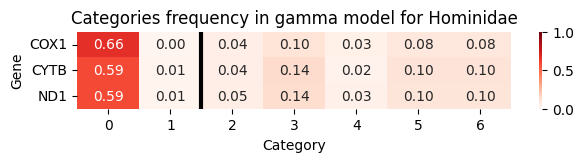

In [5]:
plt.figure(figsize=(7, 1))
plt.title("Categories frequency in gamma model for Hominidae")
sns.heatmap((hrates_cats.T / hrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.xlabel("Category")
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_human.pdf", bbox_inches="tight")
plt.show()

### MUS

In [7]:
path_to_hrates = "../data/MUS/mus_rates/"
data = []
for p in glob.glob(path_to_hrates + "*.rate"):
    d = pd.read_csv(p, sep="\t", comment="#")
    d["Gene"] = os.path.basename(p).replace(".rate", "")
    data.append(d)
mrates = pd.concat(data)

In [8]:
mrates_cats = mrates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mrates_cats

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
COX1,1064,47,44,126,53,101,110
CYTB,565,74,67,79,120,133,63
ND1,581,36,65,76,51,75,73


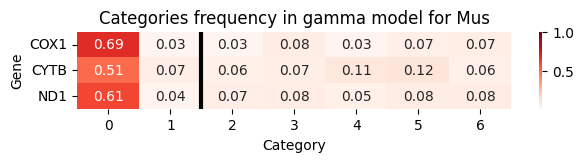

In [9]:
plt.figure(figsize=(7, 1))
plt.title("Categories frequency in gamma model for Mus")
sns.heatmap((mrates_cats.T / mrates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.xlabel("Category")
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mus.pdf", dpi=300,bbox_inches="tight")
plt.show()

### Mammals

In [27]:
data = []
d = pd.read_csv("../data/exposure/mammals_nd1/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "ND1"
data.append(d)
d = pd.read_csv("../data/exposure/mammals_cytb/iqtree.rate", sep="\t", comment="#")
d["Gene"] = "CYTB"
data.append(d)
mam_rates = pd.concat(data)

In [28]:
mam_rates_cats = mam_rates.groupby("Gene").Cat.value_counts().reset_index(name="N").pivot("Gene", "Cat", "N").fillna(0).astype(np.int16)
mam_rates_cats

Cat,0,1,2,3,4,5
Gene,,,,,,
CYTB,499,106,81,121,207,126
ND1,402,85,84,110,150,123


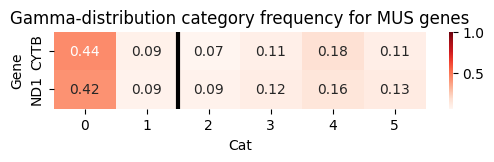

In [29]:
plt.figure(figsize=(6, 1))
plt.title("Gamma-distribution category frequency for Mammals genes")
sns.heatmap((mam_rates_cats.T / mam_rates_cats.sum(axis=1)).T, annot=True, cmap="Reds", fmt=".2f", vmax=1);
plt.vlines([2], 0, 13, 'k', linewidth=3)
plt.savefig("../figures/rates_mammals.pdf", bbox_inches="tight")
plt.show()

## Expected mutations excluding invariant positions

In [3]:
coda = CodonAnnotation(2)

In [4]:
human_cytb = [str(x.seq) for x in SeqIO.parse("../data/selection_search/human_cytb/sequences/alignment_checked.fasta", format="fasta")]
human_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/human_cytb.rate"))[1]
human_cytb_rate = pd.read_csv("../data/selection_search/rates/human_cytb.rate", comment="#", sep="\t")
human_nd1 = [str(x.seq) for x in SeqIO.parse("../data/selection_search/human_nd1/sequences/alignment_checked.fasta", format="fasta")]
human_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/human_nd1.rate"))[1]
human_nd1_rate = pd.read_csv("../data/selection_search/rates/human_nd1.rate", comment="#", sep="\t")
human_cox1 = [str(x.seq) for x in SeqIO.parse("../data/selection_search/human_cox1/sequences/alignment_checked.fasta", format="fasta")]
human_cox1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/human_cox1.rate"))[1]
human_cox1_rate = pd.read_csv("../data/selection_search/rates/human_cox1.rate", comment="#", sep="\t")

mouse_cytb = [str(x.seq) for x in SeqIO.parse("../data/selection_search/mouse_cytb/sequences/alignment_checked.fasta", format="fasta")]
mouse_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/mouse_cytb.rate"))[1]
mouse_cytb_rate = pd.read_csv("../data/selection_search/rates/mouse_cytb.rate", comment="#", sep="\t")
mouse_nd1 = [str(x.seq) for x in SeqIO.parse("../data/selection_search/mouse_nd1/sequences/alignment_checked.fasta", format="fasta")]
mouse_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/mouse_nd1.rate"))[1]
mouse_nd1_rate = pd.read_csv("../data/selection_search/rates/mouse_nd1.rate", comment="#", sep="\t")
mouse_cox1 = [str(x.seq) for x in SeqIO.parse("../data/selection_search/mouse_cox1/sequences/alignment_checked.fasta", format="fasta")]
mouse_cox1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/selection_search/rates/mouse_cox1.rate"))[1]
mouse_cox1_rate = pd.read_csv("../data/selection_search/rates/mouse_cox1.rate", comment="#", sep="\t")

for _df in [human_cytb_rate, human_nd1_rate, human_cox1_rate, mouse_cytb_rate, mouse_nd1_rate, mouse_cox1_rate]:
    _df["Pos"] = np.arange(len(_df)) + 1

mammals_cytb = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_cytb/alignment_checked.fasta", format="fasta")]
mammals_nd1 = [str(x.seq) for x in SeqIO.parse("../data/exposure/mammals_nd1/alignment_checked.fasta", format="fasta")]
mammals_cytb_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_cytb/iqtree.rate"))[1]
mammals_nd1_mask = GenesStates.get_mask(GenesStates.read_rates("../data/exposure/mammals_nd1/iqtree.rate"))[1]

In [46]:
lbl = "syn"
full_exp_summary = []

### Human CYTB

In [6]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
n = 500
for seq in random.sample(human_cytb, n):
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / n
        exp_masked12[sbs] += em12[lbl][sbs] / n

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / n
        exp_masked192[sbs] += em192[lbl][sbs] / n


In [7]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[0][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,88.380,138.456,88.380,88.072,88.072,208.096,13.422,6.814,6.814,15.132,54.838,15.132
exp_masked,61.188,88.512,61.188,61.094,61.094,146.158,12.372,6.788,6.788,15.114,54.794,15.114


In [8]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/human_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

### Human ND1

In [9]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
n = 500
for seq in random.sample(human_nd1, n):
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / n
        exp_masked12[sbs] += em12[lbl][sbs] / n

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / n
        exp_masked192[sbs] += em192[lbl][sbs] / n


In [10]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[1][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,69.98,116.774,69.98,91.522,91.522,178.406,17.112,9.004,9.004,16.208,42.158,16.208
exp_masked,49.01,77.840,49.01,73.568,73.568,134.462,17.080,8.986,8.986,15.196,39.128,15.196


In [11]:
dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/human_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

### Human COX1

In [47]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in human_cox1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, human_cox1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(human_cox1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(human_cox1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(human_cox1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(human_cox1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/human_cox1/exp_muts_invariant.tsv", sep="\t", index=False)

In [14]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[2][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,114.778,183.624,114.778,97.208,97.208,251.982,27.186,15.136,15.136,47.566,92.616,47.566
exp_masked,83.780,124.730,83.780,73.228,73.228,189.030,26.140,15.102,15.102,45.564,84.590,45.564


### Mus CYTB

In [15]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mouse_cytb:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mouse_cytb_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mouse_cytb)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mouse_cytb)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mouse_cytb)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mouse_cytb)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12[sbs]
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/mouse_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [16]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[3][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,104.497717,164.401826,104.497717,45.399543,45.399543,150.404110,9.844749,6.066210,6.066210,20.874429,87.488584,20.874429
exp_masked,98.518265,153.431507,98.518265,45.399543,45.399543,149.406393,9.828767,6.057078,6.057078,20.860731,87.474886,20.860731


### Mus ND1

In [17]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mouse_nd1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mouse_nd1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mouse_nd1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mouse_nd1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mouse_nd1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mouse_nd1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/mouse_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [18]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[4][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,93.0000,161.8125,93.0000,39.825,39.825,112.9375,10.5875,7.4375,7.4375,20.775,78.8875,20.775
exp_masked,67.3125,109.1500,67.3125,39.800,39.800,111.8875,9.7375,6.5875,6.5875,20.750,78.8625,20.750


### Mus COX1

In [19]:
exp12, exp192 = defaultdict(int), defaultdict(int)
exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
for seq in mouse_cox1:
    e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
    em12, em192 = coda.collect_exp_mut_freqs(seq, mouse_cox1_mask, [lbl])

    for sbs in e12[lbl]:
        exp12[sbs] += e12[lbl][sbs] / len(mouse_cox1)
        exp_masked12[sbs] += em12[lbl][sbs] / len(mouse_cox1)

    for sbs in e192[lbl]:
        exp192[sbs] += e192[lbl][sbs] / len(mouse_cox1)
        exp_masked192[sbs] += em192[lbl][sbs] / len(mouse_cox1)

dct = dict()
for sbs in possible_sbs12:
    dct[sbs] = exp_masked12.get(sbs, 0.)
for sbs in possible_sbs192:
    dct[sbs] = exp_masked192.get(sbs, 0.)

exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
exp_muts["Label"] = "syn"

exp_muts[["Label", "Mut", "Count"]].to_csv("../data/selection_search/mouse_cox1/exp_muts_invariant.tsv", sep="\t", index=False)

In [20]:
full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
full_exp_summary[5][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,153.762376,229.495050,153.762376,55.831683,55.831683,152.633663,17.277228,8.168317,8.168317,57.217822,153.227723,57.217822
exp_masked,111.910891,145.594059,111.910891,52.821782,52.821782,140.762376,16.217822,8.128713,8.128713,53.198020,142.198020,53.198020


### Mammals CYTB

In [41]:
# exp12, exp192 = defaultdict(int), defaultdict(int)
# exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
# for seq in mammals_cytb:
#     e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
#     em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_cytb_mask, [lbl])

#     for sbs in e12[lbl]:
#         exp12[sbs] += e12[lbl][sbs] / len(mammals_cytb)
#         exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_cytb)

#     for sbs in e192[lbl]:
#         exp192[sbs] += e192[lbl][sbs] / len(mammals_cytb)
#         exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_cytb)

# dct = dict()
# for sbs in possible_sbs12:
#     dct[sbs] = exp_masked12[sbs]
# for sbs in possible_sbs192:
#     dct[sbs] = exp_masked192.get(sbs, 0.)

# exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
# exp_muts["Label"] = "syn"

# # exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_cytb/exp_muts_invariant.tsv", sep="\t", index=False)

In [42]:
# full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
# full_exp_summary[4][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,100.181543,153.391831,100.181543,55.793495,55.793495,167.981089,13.710287,7.647504,7.647504,28.459909,83.393343,28.459909
exp_masked,100.181543,153.391831,100.181543,55.793495,55.793495,167.660363,12.711800,7.647504,7.647504,28.459909,83.272315,28.459909


### Mammals ND1

In [43]:
# exp12, exp192 = defaultdict(int), defaultdict(int)
# exp_masked12, exp_masked192 = defaultdict(int), defaultdict(int)
# for seq in mammals_nd1:
#     e12, e192  =  coda.collect_exp_mut_freqs(seq, None, [lbl])
#     em12, em192 = coda.collect_exp_mut_freqs(seq, mammals_nd1_mask, [lbl])

#     for sbs in e12[lbl]:
#         exp12[sbs] += e12[lbl][sbs] / len(mammals_nd1)
#         exp_masked12[sbs] += em12[lbl][sbs] / len(mammals_nd1)

#     for sbs in e192[lbl]:
#         exp192[sbs] += e192[lbl][sbs] / len(mammals_nd1)
#         exp_masked192[sbs] += em192[lbl][sbs] / len(mammals_nd1)

# dct = dict()
# for sbs in possible_sbs12:
#     dct[sbs] = exp_masked12[sbs]
# for sbs in possible_sbs192:
#     dct[sbs] = exp_masked192.get(sbs, 0.)

# exp_muts = pd.Series(dct).reset_index(name="Count").rename(columns={"index": "Mut"})
# exp_muts["Label"] = "syn"

# # exp_muts[["Label", "Mut", "Count"]].to_csv("../data/exposure/mammals_nd1/exp_muts_invariant.tsv", sep="\t", index=False)

In [44]:
# full_exp_summary.append(pd.DataFrame([exp12, exp_masked12], index=["exp", "exp_masked"]))
# full_exp_summary[5][possible_sbs12]

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
exp,89.97432,147.533988,89.97432,49.350453,49.350453,127.271903,12.555891,6.604985,6.604985,25.165408,71.724320,25.165408
exp_masked,89.97281,146.519637,89.97281,49.350453,49.350453,127.057402,11.577795,6.466767,6.466767,25.165408,71.642749,25.165408


### Merge Human, Mouse and Mammals

In [25]:
# a = pd.concat(full_exp_summary)
# a["Species"] = np.repeat(["Human", "Mouse", "Mammals"], 4)
# a["Gene"] = np.repeat(np.tile(["CYTB", "ND1"], 3), 2)

a = pd.concat(full_exp_summary)
a["Species"] = np.repeat(["Human", "Mouse"], 6)
a["Gene"] = np.repeat(np.tile(["CYTB", "ND1", "COX1"], 2), 2)

a.reset_index().rename(columns={"index": "Label"}).set_index(["Species", "Gene", "Label"]).round(2)

G>A    C>G    C>A     C>T     A>G     A>C     A>T  \
Species Gene Label                                                             
Human   CYTB exp         13.42  88.07  88.07  208.10  138.46   88.38   88.38   
             exp_masked  12.37  61.09  61.09  146.16   88.51   61.19   61.19   
        ND1  exp         17.11  91.52  91.52  178.41  116.77   69.98   69.98   
             exp_masked  17.08  73.57  73.57  134.46   77.84   49.01   49.01   
        COX1 exp         27.19  97.21  97.21  251.98  183.62  114.78  114.78   
             exp_masked  26.14  73.23  73.23  189.03  124.73   83.78   83.78   
Mouse   CYTB exp          9.84  45.40  45.40  150.40  164.40  104.50  104.50   
             exp_masked   9.83  45.40  45.40  149.41  153.43   98.52   98.52   
        ND1  exp         10.59  39.83  39.83  112.94  161.81   93.00   93.00   
             exp_masked   9.74  39.80  39.80  111.89  109.15   67.31   67.31   
        COX1 exp         17.28  55.83  55.83  152.63  229.50  153.76  153.76   
             exp_masked  16.22  52.82  52.82  140.76  145.59  111.91  111.91   

                            T>C    T>G    T>A    G>C    G>T  
Species Gene Label                                           
Human   CYTB exp          54.84  15.13  15.13   6.81   6.81  
             exp_masked   54.79  15.11  15.11   6.79   6.79  
        ND1  exp          42.16  16.21  16.21   9.00   9.00  
             exp_masked   39.13  15.20  15.20   8.99   8.99  
        COX1 exp          92.62  47.57  47.57  15.14  15.14  
             exp_masked   84.59  45.56  45.56  15.10  15.10  
Mouse   CYTB exp          87.49  20.87  20.87   6.07   6.07  
             exp_masked   87.47  20.86  20.86   6.06   6.06  
        ND1  exp          78.89  20.78  20.78   7.44   7.44  
             exp_masked   78.86  20.75  20.75   6.59   6.59  
        COX1 exp         153.23  57.22  57.22   8.17   8.17  
             exp_masked  142.20  53.20  53.20   8.13   8.13

## Intersection of invariant and synonymous positions

In [26]:
# for each gene in alignment get expected mutations,
# assign invariativity to each position
# and calculate how many positions are invariant

n = 500
em_total = []
for gene, aln, mask, rates in zip(
    ['human_cytb', 'human_nd1', 'human_cox1', 'mouse_cytb', 'mouse_nd1', 'mouse_cox1'], 
    [human_cytb, human_nd1, human_cox1, mouse_cytb, mouse_nd1, mouse_cox1], 
    [human_cytb_mask, human_nd1_mask, human_cox1_mask, mouse_cytb_mask, mouse_nd1_mask, mouse_cox1_mask],
    [human_cytb_rate, human_nd1_rate, human_cox1_rate, mouse_cytb_rate, mouse_nd1_rate, mouse_cox1_rate]
    ):
    em = []
    aln = random.sample(aln, n) if len(aln) > n else aln
    for seq in aln:
        em.append(coda.collect_exp_muts(seq))
    em = pd.concat(em).merge(rates, on="Pos")
    em["Gene"] = gene
    em_total.append(em)

em_total_df = pd.concat(em_total)
em_total_df["Invariant"] = (em_total_df.Cat < 2).astype(np.int8)

In [27]:
em_total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823493 entries, 0 to 111361
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Pos        int64  
 1   Pic        int64  
 2   Mut        object 
 3   Cdn        object 
 4   Label      object 
 5   Site       int64  
 6   Rate       float64
 7   Cat        int64  
 8   C_Rate     float64
 9   Gene       object 
 10  Invariant  int8   
dtypes: float64(2), int64(4), int8(1), object(4)
memory usage: 154.8+ MB


In [28]:
em_total_df.head()

,Pos,Pic,Mut,Cdn,Label,Site,Rate,Cat,C_Rate,Gene,Invariant
0,3,3,T[G>A]A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
1,3,3,T[G>A]A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
2,3,3,T[G>A]A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
3,3,3,T[G>A]A,ATG,syn,3,0.05365,0,0.0,human_cytb,1
4,3,3,T[G>A]A,ATG,syn,3,0.05365,0,0.0,human_cytb,1


In [29]:
(em_total_df.groupby("Gene").Cat.value_counts(normalize=True).unstack() * 100).round(2)
# Category frequency for possible SYN mutations

Cat,0,1,2,3,4,5,6
Gene,,,,,,,
human_cox1,22.17,NaN,4.88,23.15,8.31,19.44,22.06
human_cytb,27.27,NaN,1.85,25.86,2.47,19.02,23.53
human_nd1,22.79,0.14,3.45,24.65,5.49,20.17,23.32
mouse_cox1,18.66,5.26,4.26,20.74,8.25,18.75,24.08
mouse_cytb,3.13,0.52,6.79,14.12,23.28,30.33,21.82
mouse_nd1,15.70,2.32,11.37,17.93,9.21,18.19,25.28
